# Genome Similarities via Set Proximity Measures



## Set Similarity

(Dis-)similarity of two sets $A$ and $B$ can be measured with Jaccard similarity
$$
J(A,B) := \frac{|A \cap B|}{|A \cup B|}
$$


### Naive Algorithm

Hashmap or bitvector

**TODO** Implement jaccard_similarity() in jaccard0.cpp

Test your implementation by running
```
./build/source/jaccard0 data/ebola/sequences.fasta
```

How much memory consumption do you expect?

Let us check that in practice:

In [3]:
import os
from evaluate.track import track_memory_and_runtime, track_memory_and_runtime_similarity

files = ["corona", "ebola", "hiv", "mpox"]
jaccards = {}
for file in files:
    file_size = os.path.getsize("data/" + file + "/sequences.fasta")/(1024*1024)
    _,memory,res = track_memory_and_runtime("build/source/jaccard1", "data/" + file + "/sequences.fasta")
    jaccards.update({file: res})
    print("File size: %.1fMB" % file_size)
    print("Memory consumption: %.1fMB" % memory)

File size: 0.4MB
Memory consumption: 29.5MB
File size: 0.3MB
Memory consumption: 24.0MB
File size: 0.2MB
Memory consumption: 0.0MB
File size: 4.4MB
Memory consumption: 187.4MB


### Observations
- hashmap's space consumption linear w.r.t. number of distinct elements
- $n$ genomic sequences/hashmaps of size $O(m)$ require $O(n m)$ space.


Impractical for big genomic data.

### Naive Improvement

Randomly sample $p$ percent elements per set and compute Jaccard similarity for them.

**TODO:** Implement jaccard_similarities() in jaccard_sample0.cpp

Let us compare run time, space consumption, and accuracy to the exact algorithm:

In [4]:
probabilities = [0.1, 0.25, 0.5, 0.75, 1.0]
results = {file: [] for file in files}
for file in files:
    for prob in probabilities:
        results[file].append(track_memory_and_runtime_similarity("build/source/jaccard_sample1", "data/" + file + "/sequences.fasta", prob))

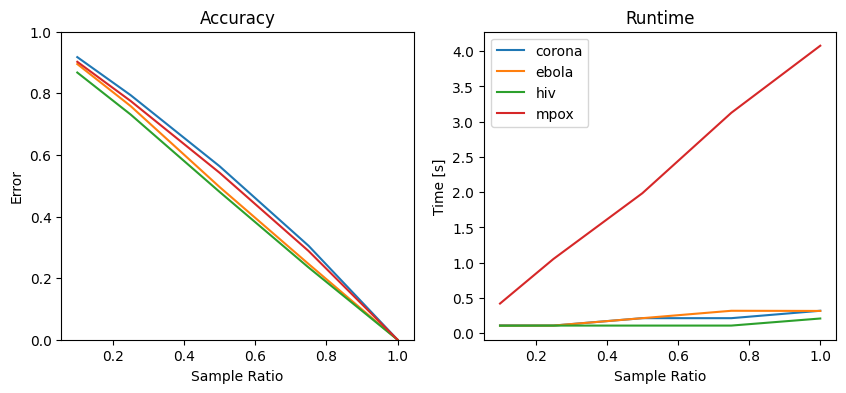

In [5]:
import numpy as np
from evaluate.plots import plot_accuracies_runtime

errors, runtimes = {}, {}
for file, result in results.items():
    jaccard = jaccards[file]
    indices = np.triu_indices(jaccard.shape[0], k=1)
    error = np.empty(len(result))
    runtime = np.empty(len(result))
    for i, (time, mem, res) in enumerate(result):
        error[i] = np.mean(np.abs(res[indices]-jaccard[indices])/jaccard[indices])
        runtime[i] = time
    errors.update({file: error})
    runtimes.update({file: runtime})

plot_accuracies_runtime(errors, runtimes, probabilities)

### MinHashing

Let $A,B$ be two sets, $h$ be a hash function, MinHash $h_{\min}(A) := \min \lbrace h(x) \mid x \in A \rbrace$ and
$$
J_h(A,B) := \begin{cases}1, & \text{if } h_{\min}(A) = h_{\min}(B)\\ 0 & \text{otw.}\end{cases},
$$
Then $J_h(A,B)$ is a random estimator of $J(A,B)$, i.e.: $E[J_h(A,B)] = J(A,B)$.
Scince $J_h$ has high variance (it is always zero or one), we average multiple independent MinHash estimators.

#### Algorithm:

- sample $h_{\min}$ from $k$ random permutations of $h$
- let $l$ be the number of permutated hash functions with $h_{\min}(A) = h_{\min}(B)$
- estimate $J(A,B)$ by $l/k$

A random permutation of $h$ can be e.g.:
$$
h_i(x) = a_i h(x) + b_i \mod p
$$
for prime number $p$ and random $a_i,b_i \in \lbrace 1,\ldots,p\rbrace$.
Or draw samples from hash family using multiple random seeds.

**TODO:** Implement minhash_similarity() in minhash0.cpp


Let us compare run time and accuracy to exact algorithm:

In [63]:
from evaluate.track import track_memory_and_runtime_similarity
import numpy as np
time_jaccard, mem_jaccard, jaccard = track_memory_and_runtime_similarity("build/source/jaccard1", "data/mpox/sequences.fasta")
time_minhash, mem_minhash, minhash = track_memory_and_runtime_similarity("build/source/minhash1", "data/mpox/sequences.fasta", 10000)
print("Runtime Hashtable: %.1fs, Minhash: %.1fs" % (time_jaccard, time_minhash))
print("Memory Hashtable: %.1fMb, Minhash: %.1fMb" % (mem_jaccard, mem_minhash))
indices = np.triu_indices(jaccard.shape[0], k=1)
error_minhash = np.abs(minhash[indices]-jaccard[indices])/jaccard[indices]
print("Error: %.1f+-%.1f%%" % (np.mean(error_minhash)*100, np.std(error_minhash)*100))

Runtime Hashtable: 3.7s, Minhash: 27.4s
Memory Hashtable: 188.5Mb, Minhash: 13.4Mb
Error: 10.3+-12.2%


 - Time and space are in $O(k)$, i.e., constant!
 - For $k = 2 \ln (2/\delta)/\epsilon^2$ the expected absolute error is at most $\epsilon$ with failure probability $\delta$.
 - What $k$ do you need for $5\% \pm 5\%$?


Let us explore the accuracy and run time of MinHash w.r.t. the number of permutations:

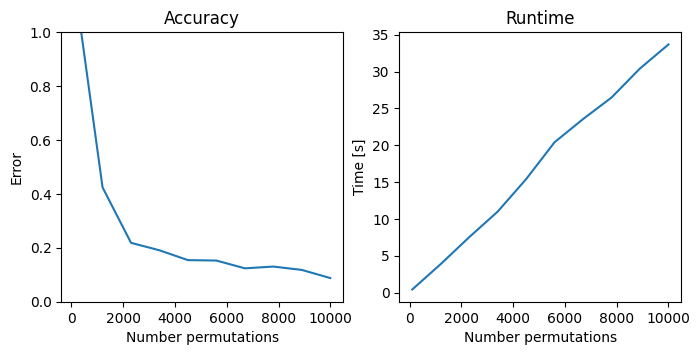

In [47]:
from evaluate.plots import plot_minhash
permutations = np.linspace(100,10000,10)
runtimes, errors = [], []
for perms in permutations:
    time, mem, res = track_memory_and_runtime_similarity("build/source/minhash1", "data/mpox/sequences.fasta", perms)
    runtimes.append(time)
    errors.append(np.mean(np.abs(res[indices]-jaccard[indices])/jaccard[indices]))
plot_minhash(errors, runtimes, permutations)

### FracMinHashing

Let $h: \Omega \Rightarrow [0,H]$ be a hash function for $H \in \mathbb{N}$ and $s \in [0,1]$ be a scaling factor. Then FracMinHash sketch
$$
FRAC_{s}(A) := \{ h(x) \mid h(x) \leq H s , x \in A \}.
$$
The Containment Index $C(A,B) = \frac{|A \cap B|}{|A|}$ is the estimate of
$$
\hat{C}_s(A,B) = \frac{|FRAC_{s}(A) \cap FRAC_{s}(B)|}{|FRAC_{s}(A)| (1-(1-s)^{|A|})}
$$
where $1/(1-(1-s)^{|A|})$ compensates the bias.

But we do not know $|A|$? Is that a problem?


**TODO:** Implement fracminhash_similarities() in fracMinHash.cpp

Note that the Jaccard similarity
$$
J(A,B) = \frac{C(A,B)|A|}{|A|+|B|-C(A,B)|A|}.
$$

Let us compare run time and accuracy to MinHash:

In [64]:
for file in files:
    time_jaccard, mem_jaccard, jaccard = track_memory_and_runtime_similarity("build/source/jaccard1", "data/" + file + "/sequences.fasta")
    time_fracminhash, mem_fracminhash, fracminhash = track_memory_and_runtime_similarity("build/source/fracminhash2", "data/" + file + "/sequences.fasta", 0.0001)
    indices = np.triu_indices(jaccard.shape[0], k=1)
    error_fracminhash = np.abs(fracminhash[indices]-jaccard[indices])/jaccard[indices]
    print("Runtime Hashtable: %.1fs, FracMinHash: %.1fs" % (time_jaccard, time_fracminhash))
    print("Memory Hashtable: %.1fMb, FracMinHash: %.1fMb" % (mem_jaccard, mem_fracminhash))
    print("Error: %.1f+-%.1f%%" % (np.mean(error_fracminhash)*100, np.std(error_fracminhash)*100))

Runtime Hashtable: 0.3s, FracMinHash: 0.4s
Memory Hashtable: 29.2Mb, FracMinHash: 20.8Mb
Error: 6.4+-2.1%
Runtime Hashtable: 0.3s, FracMinHash: 0.1s
Memory Hashtable: 23.6Mb, FracMinHash: 0.0Mb
Error: 20.5+-6.0%
Runtime Hashtable: 0.2s, FracMinHash: 0.1s
Memory Hashtable: 16.8Mb, FracMinHash: 0.0Mb
Error: 67.0+-9.4%
Runtime Hashtable: 3.7s, FracMinHash: 0.6s
Memory Hashtable: 188.0Mb, FracMinHash: 79.8Mb
Error: 0.0+-0.0%


How does the scaling factor influence accuracy and runtime?

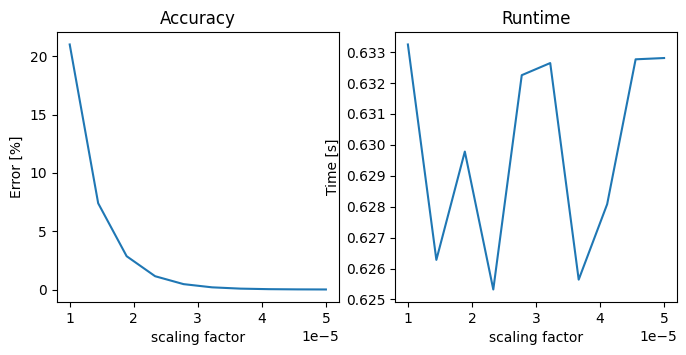

In [43]:
from evaluate.plots import plot_fracminhash
scaling_factors = np.linspace(.00001, .00005, 10)
runtimes, errors = [], []
for scaling_factor in scaling_factors:
    time, mem, res = track_memory_and_runtime_similarity("build/source/fracminhash2", "data/mpox/sequences.fasta", scaling_factor)
    runtimes.append(time)
    errors.append(np.mean(np.abs(res[indices]-jaccard[indices])/jaccard[indices])*100)
plot_fracminhash(errors, runtimes, scaling_factors)

## Take Aways

- Proximity measures for massive data sets as in molecular biology require data sketching.
- With a bit of randomness they become tractable.